In [4]:
from google.colab import drive
#drive.mount('/gdrive',force_remount=True)
#%cd /gdrive/Shareddrives/neurolusion/PhD/Exploration_Ditanglements/Notebook_CPAB_problem/
!git clone https://github.com/SkafteNicki/libcpab.git
!pip install biopython logomaker

ModuleNotFoundError: No module named 'google.colab'

In [5]:
import pdb, torch, math, matplotlib

import numpy as np
import pandas as pd

from tqdm import tqdm

import torch.nn.functional as F
from Bio.SeqIO.FastaIO import SimpleFastaParser
from dataLoaderDiffeo import *
from torch.utils.data import Dataset, DataLoader
from libcpab.libcpab import Cpab

import matplotlib.pyplot as plt
from LossFunctionsAlternatives import LossFunctionsAlternatives
from logomakers import logomaker_plots


def determine_trans_dim(raw_data,modeflag):
    '''
    In pytorch:
        In 1D: [n_batch, n_channels, number_of_features]
        In 2D: [n_batch, n_channels, width, height]
    '''
    forw=[];rev=[];outsize=()
    if modeflag=='1D':
      forw=[0,2,1]; rev=[0,2,1]
      outsize=(raw_data.shape[1],raw_data.shape[2])
    else:
      forw=[0,3,1,2]; rev=[0,2,3,1] #=> height, width
      #forw=[0,3,2,1]; rev=[0,2,3,1]
      outsize=(raw_data.shape[1],raw_data.shape[2])
    return forw,rev,outsize

def determine_trans_dim2(raw_data, ref, modeflag):
    '''
    In pytorch:
        In 1D: [n_batch, n_channels, number_of_features]
        In 2D: [n_batch, n_channels, width, height]
    '''
    forw,rev,outsize = determine_trans_dim(raw_data,modeflag)
    outsize=(ref.shape[1],ref.shape[2])
    return forw,rev,outsize


def spatial_transformation(T,raw_data,theta, modeflag):
    # Transform the images
    forw,rev,outsize = determine_trans_dim(raw_data,modeflag)
    trans_data = T.transform_data(raw_data.permute(forw), theta, outsize=outsize )

    rever_data = T.transform_data(trans_data, -theta, outsize=outsize )
    trans_data = trans_data.permute(rev)
    rever_data = rever_data.permute(rev)

    return trans_data, forw, rev

def spatial_transformation2(T, raw_data, ref, theta, modeflag):
    # Transform the images
    forw,rev,outsize = determine_trans_dim2(raw_data,ref,modeflag)
    trans_data = T.transform_data(raw_data.permute(forw), theta, outsize=outsize )

    rever_data = T.transform_data(trans_data, -theta, outsize=outsize )
    trans_data = trans_data.permute(rev)
    rever_data = rever_data.permute(rev)

    return trans_data, forw, rev

'''Main Process'''
if __name__ == "__main__":

    path = 'BLAT1_without_lowers.fasta'
    path_MSA_test = '1_Align_seq_BLAT.aln'
    device = 'gpu'
    modeflag = '2D'
    window_grid = 181#178#174 #200 for 2D

    # Reference Information - how the alignment should looks like
    alignment, ref_msa, alphabets, c2i, i2c, i2i,seqchar = read_clustal_align_output(path_MSA_test)

    # Raw Sequences, to see if we can align the sequences somehow
    dataset_msa = datasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True)
    x1 = dataset_msa.prot_space
    # reconvert the dimensions of reference and input datasets
    if modeflag == '2D':
      # convert into [#channels, #width, #height, #channels]
      x1 = x1.reshape(x1.shape[0], x1.shape[1], 1, x1.shape[2])
      ref_msa = ref_msa.reshape(ref_msa.shape[0], ref_msa.shape[1], 1, ref_msa.shape[2])
      ndim = [window_grid,1]
    else:
      ndim = [window_grid]

    '''Transformations for Reference Alignment'''
    '''-----------------------------------------------------------------------------------------------'''

    T = Cpab(ndim, backend='pytorch', device=device, zero_boundary=True,
                                             volume_perservation=False, override=False)
    #T.set_solver_params(nstepsolver=150)
    
    x1 = T.backend.to(x1, device=device)
    ref_msa = T.backend.to(ref_msa, device=device)

    theta_ref = T.sample_transformation(ref_msa.shape[0])

    '''
    Experiment one: Alignment of Sequence by using Aligned Observational Sequences as reference'''
    '''-------------------------------------------------------------------------------------------'''

    theta_est = torch.autograd.Variable(T.identity(1, epsilon=1e-6), requires_grad=True)
    #theta_est = T.backend.to(theta_est, device=device)
    #optimizer = torch.optim.Adam([theta_est], lr=0.000001)#, weight_decay=1e-7) #=> FOR CROSSENTROPY
    optimizer = torch.optim.Adam([theta_est], lr=0.01)#, weight_decay=1e-7) #=> FOR MSE
    maxiter = 10000 
    loss_function = LossFunctionsAlternatives()
    pdb.set_trace()
    msa_num = []; loss_vals =[]

    pb = tqdm(desc='Alignment of samples', unit='iters', total=maxiter)
    for i in range(maxiter):
         optimizer.zero_grad()
         #x1_trans, forw_per, rever = spatial_transformation(T, x1, theta_est, modeflag)
         x1_trans, forw_per, rever = spatial_transformation2(T, x1, ref_msa, theta_est, modeflag)
         loss = loss_function(method = 'CE', input = x1_trans, target = ref_msa, forw_per=forw_per)
         loss_vals.append(loss.item())
         loss.backward()
         optimizer.step()
         pb.update()
         pb.set_postfix({'loss': str(loss.item())})
         if modeflag == '2D':
           Softmax=torch.nn.Softmax(dim=3) # take the axis 3 from (1,172,1,20) -> over 20 aas
           x1_trans = Softmax(x1_trans)
           msa_num.append(x1_trans.argmax(-1).transpose(2,1).reshape(x1_trans.argmax(-1).transpose(2,1).shape[2]))
         else:
           Softmax=torch.nn.Softmax(dim=2) # take the axis 2 from (1,172,20) -> over 20 aas
           x1_trans = Softmax(x1_trans)
           msa_num.append(x1_trans.argmax(-1).reshape(x1_trans.argmax(-1).shape[1]))
    pb.close()

    '''
            Plotting the logos for RAW, ALIGNED (REF) and results with CPAB
            ---------------------------------------------------------------
            ---------------------------------------------------------------
    '''

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabets]; i2c['0']='X'
    if modeflag == '1D':
      x1_logo_input = x1.argmax(-1).reshape(x1.argmax(-1).shape[1])
      x1_trans_logo_input = x1_trans.argmax(-1).reshape(x1_trans.argmax(-1).shape[1])
      ref_logo_input = ref_msa.argmax(-1).reshape(ref_msa.argmax(-1).shape[1])
    else:
      x1_logo_input = x1.argmax(-1).transpose(2,1).reshape(x1.argmax(-1).transpose(2,1).shape[2])
      x1_trans_logo_input = x1_trans.argmax(-1).transpose(2,1).reshape(x1_trans.argmax(-1).transpose(2,1).shape[2])
      ref_logo_input = ref_msa.argmax(-1).transpose(2,1).reshape(ref_msa.argmax(-1).transpose(2,1).shape[2])


    logos_raw =logomaker_plots( alphabets, c2i, i2c, i2i, torch.stack([ x1_logo_input for i in range(10000)]) ) 
    logos_raw.generate_information_matrix()

    logos_alignment =logomaker_plots( alphabets, c2i, i2c, i2i, torch.stack([ ref_logo_input for i in range(10000)]) ) 
    logos_alignment.generate_information_matrix()

    #Logo of best one
    best_one = msa_num[loss_vals.index(min(loss_vals))]
    logos_best =logomaker_plots( alphabets, c2i, i2c, i2i, torch.stack([ best_one for i in range(10000)]) ) 
    logos_best.generate_information_matrix()

    #logomaker.list_font_names()
    #msa_num = torch.stack(msa_num)
    logos =logomaker_plots( alphabets_logo, c2i, i2c, i2i, torch.stack(msa_num))
    logos.generate_information_matrix()


tmp


/pytorch_projects/Notebook_CPAB_problem/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## Short test for seeing what is going on with the vector fields ploting
---------------------------------------------------------------------------
---------------------------------------------------------------------------
---------------------------------------------------------------------------

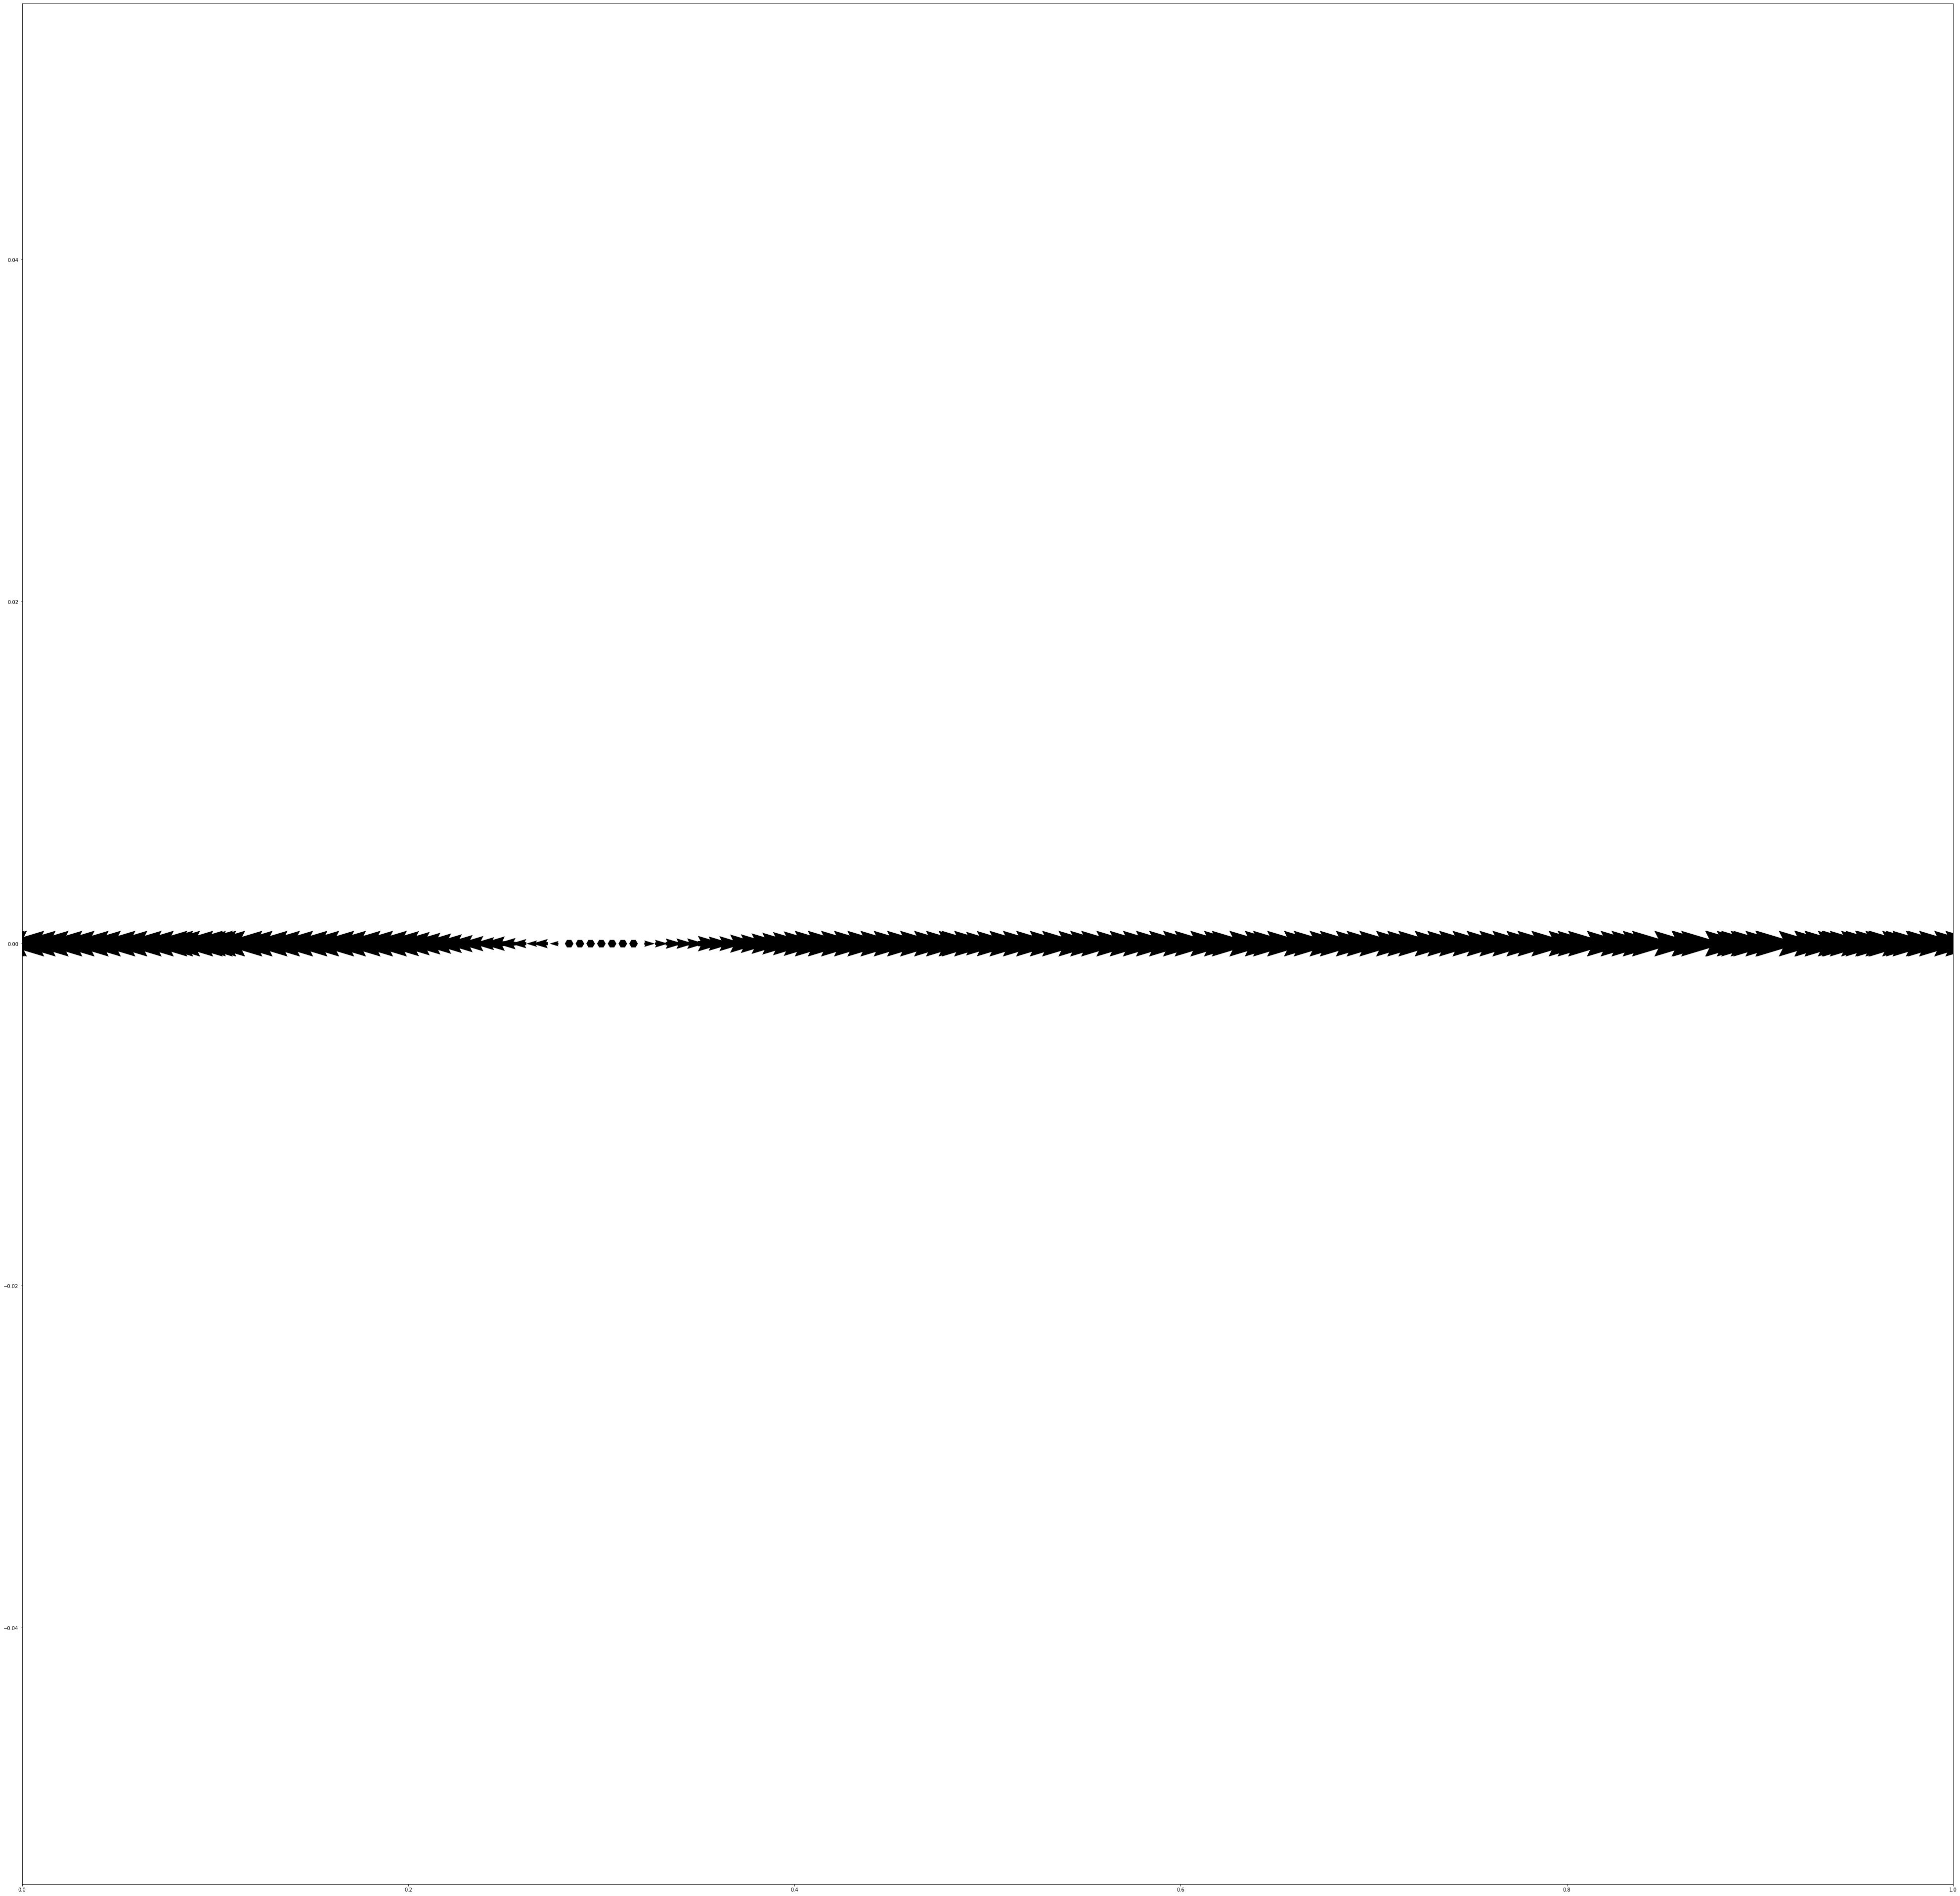

In [ ]:
T = Cpab(ndim, backend='numpy', device='cpu', zero_boundary=True,
                                             volume_perservation=False, override=False)

theta_estimation = T.backend.to(theta_est.cpu().clone().detach(), device='cpu')

#grid = T.uniform_meshgrid([window_grid for _ in range(T.params.ndim)])
grid = T.uniform_meshgrid([window_grid,1])
v = T.calc_vectorfield(grid, theta_estimation)
v = T.backend.tonumpy(v)
grid = T.backend.tonumpy(grid)

#import pdb; pdb.set_trace()
# Plot
if T.params.ndim == 1:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.quiver(grid[0,:], np.zeros_like(grid), v, np.zeros_like(v), units='xy')
    ax.set_xlim(T.params.domain_min[0], T.params.domain_max[0])
elif T.params.ndim == 2:
    fig, ax = plt.subplots(figsize=(70, 70))
    ax.quiver(grid[0,:], grid[1,:], v[0,:], v[1,:], units='xy')
    ax.set_xlim(T.params.domain_min[0], T.params.domain_max[0])
    #ax.set_ylim(-T.params.domain_min[0], T.params.domain_max[1]) 

Just a try to plot deformation in 1D

In [ ]:
nb_lines = 174
nb_points = 174
fig, ax = plt.subplots(figsize=(60, 60))


if T.params.ndim == 2:
    x = np.linspace(0,1,nb_lines)
    y = np.linspace(0,1,3)
    plots = []

    plt.grid(color="lightgrey")
    for i in range(nb_lines):
        xx = x[i]*np.ones((1,nb_points))
        yy = np.linspace(0,1,nb_points).reshape(1,nb_points)
        grid = tmp =np.concatenate((xx, yy), axis=0)
        grid = T.transform_grid(grid, theta_estimation)[0]
        plot = plt.plot(grid[0], grid[1], '-k',color="C0")
        plots.append(plot)
        plot2 = plt.plot(tmp[0], tmp[1], '-k',color="lightgrey")
        plots.append(plot2)

    '''
    for i in range(nb_lines):
        xx = np.linspace(0,1,nb_points).reshape(1,nb_points)
        yy = y[i]*np.ones((1,nb_points))
        grid = np.concatenate((xx, yy), axis=0)
        grid = T.transform_grid(grid, theta_estimation)[0]
        plot = plt.plot(grid[0], grid[1], '-k')            
        plots.append(plot)
    '''
else:
    raise NotImplementedError('This is only implemented for 2D domain')

Output hidden; open in https://colab.research.google.com to view.

---------------------------------------------------------------------------
---------------------------------------------------------------------------
---------------------------------------------------------------------------

In [ ]:
# visualize the deformations and velocity fields, something happends with the creation of the grid, just works in numpy for plotting. Bug from repo
T = Cpab(ndim, backend='numpy', device='cpu', zero_boundary=True,
                                             volume_perservation=False, override=False)

theta_estimation = T.backend.to(theta_est.cpu().clone().detach(), device='cpu')

T.visualize_vectorfield(theta_estimation,nb_points = window_grid, fig = plt.figure(figsize=(40, 40)) )
plt.show()

if modeflag == '2D':
  T.visualize_deformgrid( theta_estimation, nb_lines = window_grid, nb_points = window_grid, fig = plt.figure(figsize=(40, 40)) )
  plt.show()

T.visualize_tesselation(nb_points = window_grid, show_outside=False,fig = plt.figure(figsize=(40, 40)) )
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("Initial Sequence")
print(x1.argmax(-1).reshape(x1.argmax(-1).shape[1]))
print("\n\n")

print("Reference Sequence")
print(ref_msa.argmax(-1).reshape(ref_msa.argmax(-1).shape[1]))
print("\n\n")

print("Estimate by CPAB")
print(msa_num[loss_vals.index(min(loss_vals))])
#print(msa_num[len(msa_num)-1])
print("\n\n")

Initial Sequence
tensor([14, 10, 15,  4, 10,  4, 16, 17,  5,  3,  6, 15, 10,  6,  5, 18,  1, 10,
         3, 17,  1, 17,  6,  1, 15,  8,  1,  7, 15,  6,  3,  4, 15,  5, 13,  5,
         2, 16, 17, 16,  9, 11, 11, 10,  2,  1,  1, 18, 10,  1, 15, 16,  1,  6,
         4, 13,  1, 10, 10, 14, 15, 15,  8,  1, 19,  1,  9,  6,  3, 10,  8, 15,
        19, 16, 13,  8, 17,  4, 14,  7, 18,  6,  1,  6, 11, 16, 18,  1,  4, 10,
         2,  1,  1, 17, 10, 14, 19, 16,  3, 12, 17,  1,  1, 12, 10, 10,  8,  1,
        10, 10,  6,  6, 13, 14,  1, 18, 17,  1, 19,  1, 15, 16,  8,  6,  3,  1,
        17,  5, 15, 10,  3, 15, 15,  4, 13,  4, 10, 12, 17,  1, 10, 13,  6,  3,
         4, 15,  3, 17, 17, 17, 13,  1,  1, 11,  1,  1, 16, 18,  7, 15, 10, 10,
        18,  6,  3,  1, 10,  6,  1,  1, 16], device='cuda:0')



Reference Sequence
tensor([ 0,  0, 14, 10, 15,  4, 10,  4, 16, 17,  5,  3,  6, 15, 10,  6,  5, 18,
         1, 10,  3,  0, 17,  1, 17,  6,  1, 15,  8,  1,  7, 15,  6,  3,  4, 15,
         5, 13,  5,

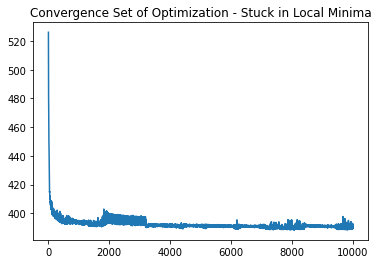

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Convergence Set of Optimization - Stuck in Local Minima')
ax1.plot(list(range(len(loss_vals))), loss_vals)